<a href="https://colab.research.google.com/github/ronitagarwala01/NASA_GCN_ML/blob/main/Copy_of_TopicModellingwithGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# In this notebook we will use Topic Modelling techniques to analyze the unstructured textual data of NASA GCN Circulars and try to extract useful topics from them for trend analysis.<br><br>
# The method we will be using in this notebook is called Latent Dirichlet Allocation or LDA. It is a method first used for Topic Modelling by Blei et al. in their 2003 paper 'Latent Dirichlet Allocation'.<br><br>
# It is considered a state of the art method for Topic Modelling and shall serve as a good baseline for our future models.

---



#Step 1: Import Modules

In [ ]:
'''
Author: Ronit Agarwala
Title: NLP Analysis of GCN Data
Last Edited: 07/21/2023
'''

!pip install pyLDAvis==2.1.2

import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import nltk.collocations as collocations
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models import phrases
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
from collections import Counter
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import tarfile
import os

nltk.download('punkt') #NLTK package for tokenization
nltk.download('stopwords') #NLTK package for stopwords list
nltk.download('wordnet') #NLTK package for lemmatization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97717 sha256=1ba2f693860047b30704692da42e09aed83bec0e06ef662f64916242ca2d642a
  Stored in directory: /root/.cache/pip/wheels/d9/93/d6/16c95da19c32f037fd75135ea152d0df37254c25cd1a8b4b6c
Successfully built pyLDAvis


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#Step 2: Data Extraction

In [ ]:
'''
Extract GCN Circulars from .tar.gz file to a new unzipped folder.
Store the path for each circular in the unzipped folder in list 'dir'.
'''

file = tarfile.open('./all_gcn_circulars.tar.gz')
file.extractall('./all_gcn_circulars')
file.close()

dir = os.listdir('./all_gcn_circulars/gcn3') #Store all file names as strings in dir

#Add file path to beginning of file names in dir
for i in range(len(dir)):
  dir[i] = './all_gcn_circulars/gcn3/' + dir[i]

print(f"Number of circulars: {len(dir)}")
print(f"First circular path: {dir[0]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of circulars: 33653
First circular path: ./all_gcn_circulars/gcn3/17073.gcn3


In [ ]:
'''
Iterate through each path in dir.
Store the text in each in list 'circulars' after converting to lower case.
Also store all circulars in a single concatenated string 'all_text'.
We will be skipping the 'From:', 'Submitted By:' and author name paragraphs in the circulars.
'''

circulars = [] #List to store the text of each GCN
full_text = '' #String to store entire corpus of data
author_name_format = re.compile(r"\b((([a-z]\. )+[a-z]+)|([a-z]+ et\.? al\.?))\b") #Regex to recognize author names
special_char_format = re.compile(r"[^\x00-\x7F]") #Regex to recognize special characters

for circular in dir:
  with open(circular, encoding = "ISO-8859-1") as f:
    new_circular = ''
    line_iter = iter(f)
    for line in line_iter:
      line = line.lower()
      if line[0:5] == 'from:': #Skipping 'From:' line
        line = next(line_iter)
        if line[0:9] == 'submitted': #Skipping 'Submitted:' line
          line = next(line_iter)
        while line == '\n' or line[-2:] == ',\n' or line[-4:] == 'and\n': #Skipping author paragraph
          line = next(line_iter)
        continue

      line = special_char_format.sub('', line) #Remove special characters
      line = author_name_format.sub('', line) #Remove author names
      new_circular += line

    circulars.append(new_circular)
    full_text += new_circular


print(circulars[0]) #Print first circular

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


title:   gcn circular
number:  17073
subject: ipn triangulation of grb 141118a
date:    14/11/20 13:12:27 gmt
behalf of the grs-odyssey grb team,

, , 'shin, , 
, and  on behalf of the konus-wind team,

, , , w.
hajdas, and , on behalf of the rhessi grb team, 

, , , , and , on behalf of
the swift-bat team,

, on behalf of the messenger ns grb team, and 

, , , and , on behalf of the fermi
gbm team, report:

grb 141118a has been observed by fermi gbm, konus-wind, rhessi, swift
(outside the coded field of view), odyssey (hend), and messenger
(grns), so far, at 58550 s (16:15:50 ut) so far.  we have triangulated
it to a preliminary, 3 sigma error box whose area is 2890 sq. arcmin.
and whose coordinates are:

              ra(2000)                      dec(2000)
center:  156.874 o =10 h 27 m 30 s     19.079 o= 19 o 04 ' 45 "
corners: 157.620 o =10 h 30 m 29 s     21.134 o= 21 o 08 ' 01 "
         156.676 o =10 h 26 m 42 s     19.104 o= 19 o 06 ' 15 "
         157.071 o =10 h 28 m 17 s    

In [ ]:
'''
Print first 100 characters of full_text, along with total length
'''

print(full_text[:100])
print(f"\nLength of full text: {len(full_text)} characters")

title:   gcn circular
number:  17073
subject: ipn triangulation of grb 141118a
date:    14/11/20 13:

Length of full text: 46882240 characters


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Step 3: Tokenization



In [ ]:
'''
Split corpus word by word.
Store each word as a token.
'tokens' is a list of lists. Each inner list is a single GCN circular tokenized.
'all_tokens' is a list of all GCN Circulars tokenized together.
'''

tokens = [] #List of lists
all_tokens = [] #List

for gcn in circulars:
  token_list = nltk.word_tokenize(gcn)
  tokens.append(token_list)
  all_tokens.extend(token_list)

print(f"Number of tokenized GCN Circulars: {len(tokens)}")
print(f"First GCN Circular tokenized: {tokens[0]}")
print(f"Number of tokens in first GCN Circular: {len(tokens[0])}")
print(f"Number of tokens in full text: {len(all_tokens)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of tokenized GCN Circulars: 33653
First GCN Circular tokenized: ['title', ':', 'gcn', 'circular', 'number', ':', '17073', 'subject', ':', 'ipn', 'triangulation', 'of', 'grb', '141118a', 'date', ':', '14/11/20', '13:12:27', 'gmt', 'behalf', 'of', 'the', 'grs-odyssey', 'grb', 'team', ',', ',', ',', "'shin", ',', ',', ',', 'and', 'on', 'behalf', 'of', 'the', 'konus-wind', 'team', ',', ',', ',', ',', 'w.', 'hajdas', ',', 'and', ',', 'on', 'behalf', 'of', 'the', 'rhessi', 'grb', 'team', ',', ',', ',', ',', ',', 'and', ',', 'on', 'behalf', 'of', 'the', 'swift-bat', 'team', ',', ',', 'on', 'behalf', 'of', 'the', 'messenger', 'ns', 'grb', 'team', ',', 'and', ',', ',', ',', 'and', ',', 'on', 'behalf', 'of', 'the', 'fermi', 'gbm', 'team', ',', 'report', ':', 'grb', '141118a', 'has', 'been', 'observed', 'by', 'fermi', 'gbm', ',', 'konus-wind', ',', 'rhessi', ',', 'swift', '(', 'outside', 'the', 'coded', 'field', 'of', 'view', ')', ',', 'odyssey', '(', 'hend', ')', ',', 'and', 'messenger', 

#Step 4: Remove Stopwords and other Uninformative Tokens


In [ ]:
'''
We will first use nltk's list of English stopwords to populate our stopwords list with words like 'a', 'the', etc.
We will also add punctuations to our stopwords list as they aren't useful for topic modelling.
Finally we will append all urls, emails, and numeric tokens to our stopwords list as well.
We filter our token lists simultaneously.
'''

stop_words = stopwords.words('english') #NLTK standard list of stopwords
punctuation_list = list(string.punctuation) #Standard list of punctuations
stop_words.extend(punctuation_list)

email_list = []
url_list = []
num_list = []
author_list = []
num_format = re.compile(r".*\d") #Regex for any number containg string
author_format = re.compile(r"([a-z]\.)+[a-z]+") #Regex for any remaining author names

cleaned_tokens=[] #List of lists
cleaned_all_tokens = [] #List

for i, token_list in enumerate(tokens):
  j = 0
  cleaned_tokens.append([])
  while j < len(token_list):
    isNum = re.match(num_format, token_list[j])
    isAuthor = re.match(author_format, token_list[j])

    if token_list[j] == 'http' or token_list[j] == 'https': #URL check
      url_list.append(token_list[j] + token_list[j+1] + token_list[j+2])
      j += 3

    elif j != len(token_list)-1 and token_list[j+1] == '@': #e-mail check
      email_list.append(token_list[j] + token_list[j+1] + token_list[j+2])
      j += 3

    elif isNum: #Number check
      num_list.append(token_list[j])
      j += 1

    elif isAuthor: #Author check
      author_list.append(token_list[j])
      j += 1

    elif token_list[j] in stop_words:
      j += 1

    else:
      cleaned_tokens[i].append(token_list[j])
      cleaned_all_tokens.append(token_list[j])
      j += 1

stop_words.extend(email_list)
stop_words.extend(url_list)
stop_words.extend(num_list)
stop_words.extend(author_list)
stop_words = list(set(stop_words)) #Remove duplicates

print(f"First 100 stopwords are: {stop_words[:100]}")
print(f"First 100 URLs are: {url_list[:100]}")
print(f"First 100 e-mails are: {email_list[:100]}")
print(f"First 100 numeric tokens are: {num_list[:100]}")
print(f"First 100 author name tokens are: {author_list[:100]}")
print(f"Current number of stopwords is: {len(stop_words)}\n")

print(f"First GCN Circular before stopword removal: {tokens[0]}")
print(f"Length of first GCN Circular before stopword removal: {len(tokens[0])}")
print(f"Length of full text before stopword removal: {len(all_tokens)}\n")

tokens = cleaned_tokens[:]
all_tokens = cleaned_all_tokens[:]

print(f"First GCN Circular after stopword removal: {tokens[0]}")
print(f"Length of first GCN Circular after stopword removal: {len(tokens[0])}")
print(f"Length of full text after stopword removal: {len(all_tokens)}")
print(f"Total number of filtered GCN Circulars: {len(tokens)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First 100 stopwords are: ['t-58.08', '-6.354', '01:17:16.003', '18251', '58710.49475', '85/88', '40734', '2021-01-02', '-41.9943', '119.66521', '34626', '1.960', '11030', 'z~1.7', 'http://observ.pereplet.ru/images/grb081130b/grb_film.html', '+10:00:02.9232', 'https://gw-astronomy.org/wiki/lv_em/curluploadfootprints', '07:11:43', '20:57:26', '-175.94', '310.911', '16.15+/-0.35', '17.2968', '11832', '8.02e-10', '09:12:16', '15:33:15', '37.77', '15:49:58', '21:09:30', '-43.86', 'dec=-69.73395', '110112', "|g'=19.82+/-0.33", '13:49:26', '255.20192', '8.64e-04', 'grb070802', '20:50:48', 'grb200619.25', '-47.7080', '24727', '09:22:16', '16.71', '9-15', 't0+88.42', '170921a', 'g0738566', '09/07/14', '1013-0049721', '-6.772099', '03:50:02', '-04:23:43.4', '0818-50', '+38.626d', 'grb210610b', '+27.572', 'g1207128', '22601', '17:59:41', '+1.1', '10:06:19.0', '10dec05', '10876', '2.50s', '17/03/11', '+76', '649684549,14h', '58710.41345', '+41.979', 'z~7-8', '9.1e-09', '22:00:52', '17175', '22.3.'

#Step 5: Lemmatization

In [ ]:
'''
Lemmatize or convert each token to its root form. E.g. 'uses' and 'using' becomes 'use'
Helps reduce dimensionality of data for Topic Modelling
We use nltk.stem's WordNetLemmatizer for this purpose.
'''

lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [] #List of lists
lemmatized_all_tokens = [] #List

for i, token_list in enumerate(tokens):
  lemmatized_tokens.append([])
  for j in range(len(token_list)):
    lemma = lemmatizer.lemmatize(token_list[j])
    lemmatized_tokens[i].append(lemma)
    lemmatized_all_tokens.append(lemma)

print(f"First GCN Circular before lemmatization: {tokens[0]}")
print(f"Total number of tokens before lemmatizaton: {len(all_tokens)}\n")

tokens = lemmatized_tokens[:]
all_tokens = lemmatized_all_tokens[:]

print(f"First GCN Circular after lemmatization: {tokens[0]}")
print(f"Total number of tokens after lemmatizaton: {len(all_tokens)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First GCN Circular before lemmatization: ['title', 'gcn', 'circular', 'number', 'subject', 'ipn', 'triangulation', 'grb', 'date', 'gmt', 'behalf', 'grs-odyssey', 'grb', 'team', "'shin", 'behalf', 'konus-wind', 'team', 'w.', 'hajdas', 'behalf', 'rhessi', 'grb', 'team', 'behalf', 'swift-bat', 'team', 'behalf', 'messenger', 'ns', 'grb', 'team', 'behalf', 'fermi', 'gbm', 'team', 'report', 'grb', 'observed', 'fermi', 'gbm', 'konus-wind', 'rhessi', 'swift', 'outside', 'coded', 'field', 'view', 'odyssey', 'hend', 'messenger', 'grns', 'far', 'ut', 'far', 'triangulated', 'preliminary', 'sigma', 'error', 'box', 'whose', 'area', 'sq', 'arcmin', 'whose', 'coordinates', 'ra', 'dec', 'center', 'h', 'o=', '``', 'corners', 'h', 'o=', '``', 'h', 'o=', '``', 'h', 'o=', '``', 'h', 'o=', '``', 'error', 'box', 'may', 'improved', 'map', 'posted', 'details', 'burst', 'given', 'forthcoming', 'gcn', 'circular']
Total number of tokens before lemmatizaton: 3657266

First GCN Circular after lemmatization: ['title

#Step 6: Frequency Statistics

In [ ]:
'''
Get frequency distribution of all tokens.
Save the 1500 most common tokens and print them out.
'''
frequencies = FreqDist(all_tokens)
most_common_tokens = frequencies.most_common(1500)
freq_word_list = [t[0] for i, t in enumerate(most_common_tokens)]
print(f"Most common tokens with their frequencies: {most_common_tokens}")
print(f"Most common tokens by themselves: {freq_word_list}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Most common tokens with their frequencies: [('--', 162605), ('gcn', 91667), ('grb', 71399), ('observation', 40388), ('date', 36003), ('number', 34477), ('subject', 33772), ('circular', 33719), ('title', 33597), ('gmt', 33570), ('burst', 32245), ('trigger', 31599), ('source', 28352), ('ut', 26719), ('data', 25810), ('position', 25748), ('report', 25565), ('kev', 24932), ('time', 24163), ('bat', 22891), ("''", 22492), ('swift', 22042), ('error', 21982), ('sec', 21774), ('c', 21554), ('ra', 21240), ('dec', 20964), ('team', 18468), ('+/-', 18413), ('telescope', 17882), ('image', 17494), ('limit', 17438), ('optical', 17218), ('xrt', 17037), ('deg', 16152), ('analysis', 15867), ('spectrum', 15441), ('behalf', 15421), ('afterglow', 15384), ('field', 15261), ('observed', 14805), ('peak', 14096), ('fermi', 14095), ('x', 14015), ('using', 13991), ('upper', 13853), ('band', 13530), ('detected', 13490), ('gbm', 13463), ('observatory', 13447), ('magnitude', 13208), ('exposure', 13157), ('light', 13

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


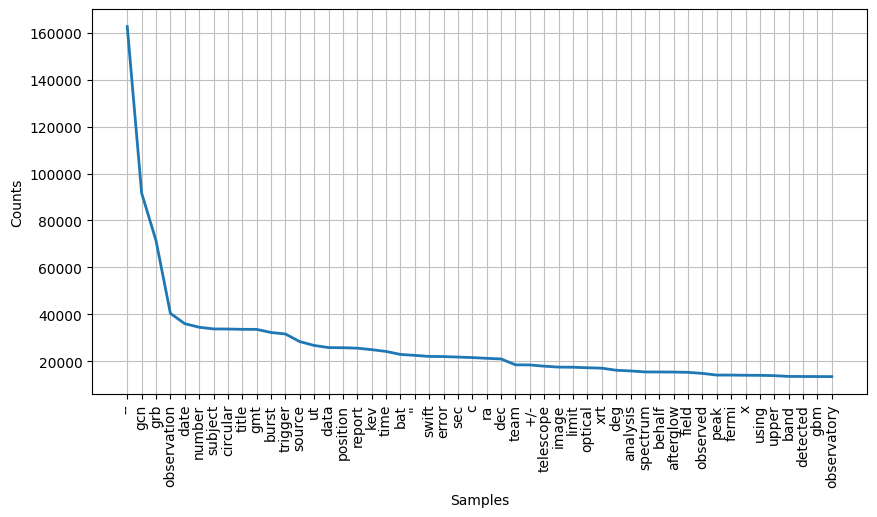

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
'''
Plot a line graph for the 50 most common tokens.
'''

fig, ax = plt.subplots(figsize=(10,5))
frequencies.plot(50) #Frequencies of 50 most common words as a line chart

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


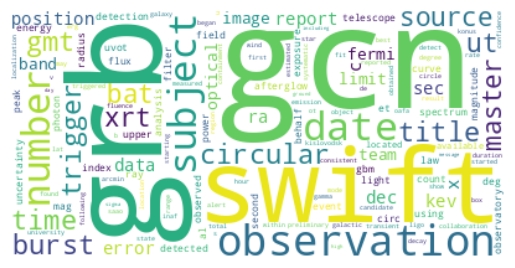

In [ ]:
'''
Generate a word cloud to help visualize the entire corpus.
'''

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join(all_tokens))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()



---


We see that there are still a lot of commonly occuring words that provide no useful information regarding the circular's content. Words like 'title', 'et', 'al', etc. can be removed without sacrificing the Topic Model's accuracy. Doing so will also help considerably speed up our computations.<br><br>
Additionally, we can also remove words that occur very infrequently, as they too provide little to no useful information. We will set a threshold value of 10 here. Thus, any words that occur 10 or less times in the entire corpus are removed.<br><br>
Thus, we are using a hybrid version of manual and bottom filtering to filter out additional stopwords from our corpus.


---



#Step 7: Stopword Removal (Part 2)

In [ ]:
'''
Create a new list of custom stopwords.
We have carefully curated a list of over 1500 stopwords by going through the entire text.
Note this list is not comprehensive.
'''

new_stopwords = []
with open('custom_stopwords.txt') as f:
  for word in f:
    new_stopwords.append(word.lower().strip())

print(new_stopwords)
print(len(new_stopwords))

['better', 'umd', 'g.', 'common', 'kocevski', 'information', 'scheduled', 'australia', 'mansi', 'astrometric', 'located', 'sai', 'svinkin', 'downlinked', 'facilitated', 'within', 'fade', 'acknowledgement', 'ph/cmsq/s', 'without', 'a.pozanenko', 'operator', 'february', 'evans', 'andrew', 'author', 'mssl/ucl', 'unam', 'relatively', 'ngc', 'paper', 'operation', 'enrico', 'inconvenience', 'ongoing', 'pasquale', 'agreement', 'antarctic', 'lie', 'p-value', 'error', 'containment', 'table', 'aug', '|â', 'subsequent', 'm', 'de', 'ep', 'ori', 'summary', 'alert', 'final', 'u', 'circl', 'observed', 'pc', 'mod', 'sbarufatti', 'region', 'estimate', 'mjy', 'server', 'fully', 'carlos', 'noted', 'note', 'comparison', 'fluctuation', 'exposition', 'cts/', 'urgent', '_________|_____________________|_____________________|____________________________________|_____|_______|_______|________', 'g.beskin', 'berger', 'zero', 'e', 'analysis', 'figure', 'imaging', "'elia", 'smaller', 'corresponds', 'z', 'intrinsic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
Carefully select custom list of keywords as well from our whole corpus.
Keywords are those words that occur very often but are deemed to be informative...
...of the topics of their respective documents.
'''

key_words = []
with open('custom_keywords.txt') as f:
  for word in f:
    key_words.append(word.lower().strip())

print(key_words)
print(len(key_words))

['kw', 'gtc', 'alignment', 'swift/xrt', 'ligo/virgo', 'swift-bat', 'spectroscopy', 'sgm', 'crao', 'swift/bat', 'konus', 'telemetry', 'mcal', 'keck', 'maxi', 'optical/nir', 'counterpart', 'bright', 'agile', 'multi-messenger', 'calern', 'swift-xrt', 'master', 'coding', 'cxou', 'pan-starrs', 'host', 'kait', 'polar', 'compact', 'swift/bat-guano', 'master-amur', 'reionization', 'swift', 'grbs', 'soft', 'peak', 'rem', 'pole', 'wave', 'tng', 'calet', 'bepposax', 'gravitational', 'low-energy', 'silla', 'hst', 'vla', 'wfc', 'xrt', 'galaxy', 'solar', 'absorption', 'ibis/veto', 'unabsorbed', 'supernova', 'galactic', 'outburst', 'sn', 'swift/uvot', 'lvc', 'cal', 'anticoincidence', 'batse', 'cluster', 'virgo', 'ras', 'hend', 'xmm-newton', 'fermilab', 'tarot', 'fregate', 'jfov', 'palomar', 'bayestar', 'emission', 'ipn', 'master-iac', 'balrog', 'short-duration', 'grb', 'photometric', 'ulysses', 'gecam', 'suzaku', 'fram-auger', 'grond', 'master-saao', 'ztf', 'iac', 'skynet', 'ligo-virgo', 'ray', 'redd

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
Filter out new stopwords.
Also filter out words with frequency less than or equal to 10.
'''

cleaned_tokens=[]
cleaned_all_tokens = []

for i, token_list in enumerate(tokens):
  cleaned_tokens.append([])
  for token in token_list:
    if token not in new_stopwords and frequencies[token] > 10:
    # if frequencies[token] > 10:
    # if token in key_words:
      cleaned_tokens[i].append(token)
      cleaned_all_tokens.append(token)
    else:
      stop_words.append(token)

print(f"First GCN Circular before stopword removal: {tokens[0]}")
print(f"Length of first GCN Circular before stopword removal: {len(tokens[0])}")
print(f"Length of full text before stopword removal: {len(all_tokens)}\n")

tokens = cleaned_tokens[:]
all_tokens = cleaned_all_tokens[:]
stop_words = list(set(stop_words))

print(f"First GCN Circular after stopword removal: {tokens[0]}")
print(f"Length of first GCN Circular after stopword removal: {len(tokens[0])}")
print(f"Length of full text after stopword removal: {len(all_tokens)}")
print(f"Total number of filtered GCN Circulars: {len(tokens)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First GCN Circular before stopword removal: ['title', 'gcn', 'circular', 'number', 'subject', 'ipn', 'triangulation', 'grb', 'date', 'gmt', 'behalf', 'grs-odyssey', 'grb', 'team', "'shin", 'behalf', 'konus-wind', 'team', 'w.', 'hajdas', 'behalf', 'rhessi', 'grb', 'team', 'behalf', 'swift-bat', 'team', 'behalf', 'messenger', 'n', 'grb', 'team', 'behalf', 'fermi', 'gbm', 'team', 'report', 'grb', 'observed', 'fermi', 'gbm', 'konus-wind', 'rhessi', 'swift', 'outside', 'coded', 'field', 'view', 'odyssey', 'hend', 'messenger', 'grns', 'far', 'ut', 'far', 'triangulated', 'preliminary', 'sigma', 'error', 'box', 'whose', 'area', 'sq', 'arcmin', 'whose', 'coordinate', 'ra', 'dec', 'center', 'h', 'o=', '``', 'corner', 'h', 'o=', '``', 'h', 'o=', '``', 'h', 'o=', '``', 'h', 'o=', '``', 'error', 'box', 'may', 'improved', 'map', 'posted', 'detail', 'burst', 'given', 'forthcoming', 'gcn', 'circular']
Length of first GCN Circular before stopword removal: 97
Length of full text before stopword removal:

In [ ]:
'''
As an extended cleaning step, we will also remove GCN Circulars that are empty.
These circulars should ideally not belong to any topic cluster, so it's best to remove them before training.
'''

deleted = []
for i, token_list in enumerate(tokens):
  if len(token_list) == 0:
    deleted.append(tokens.pop(i))

print(f"The number of deleted GCN Circulars are: {len(deleted)}")

The number of deleted GCN Circulars are: 41


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
Save all keywords, stopwords, etc. to files for future reference
'''

with open('most_common_1500_words.txt','w') as f:
  for word in freq_word_list:
    f.write(word+"\n")

with open('extra_stopwords.txt','w') as f:
  for word in new_stopwords:
    f.write(word+"\n")

with open('keywords.txt','w') as f:
  for word in key_words:
    f.write(word+"\n")

with open('emails.txt','w') as f:
  for word in email_list:
    f.write(word+"\n")

with open('urls.txt','w') as f:
  for word in url_list:
    f.write(word+"\n")

with open('numbers.txt','w') as f:
  for word in num_list:
    f.write(word+"\n")

with open('authors.txt','w') as f:
  for word in author_list:
    f.write(word+"\n")

with open('all_stopwords.txt','w') as f:
  for word in stop_words:
    if isinstance(word, str):
      f.write(word+"\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(author_list[:100])

['d.o.f.', 'v.vladimirov', 'i.gorbunov', 'd.zimnukhov', 'v.senik', 't.pogrosheva', 'd.kuvshinov', 'c.lopez', 'c.francile', 'h.levato', 'o.ershova', 'i.e', 'v.vladimirov', 'i.gorbunov', 'd.zimnukhov', 'v.senik', 't.pogrosheva', 'd.kuvshinov', 'c.lopez', 'c.francile', 'h.levato', 'o.ershova', 'd.o.f.', 'd.o.f.', 'u.leicester', 'i.e.', 'd.o.f.', 'd.o.f.', 'v.vladimirov', 'i.gorbunov', 'd.zimnukhov', 'v.senik', 't.pogrosheva', 'd.kuvshinov', 'c.lopez', 'c.francile', 'h.levato', 'o.ershova', 'n.isobe', 's.sugita', 'r.imatani', 'r.a.', 'i.e.', 'r.a.', 'i.e', 'a.j', 'r.a.', 'g.antipov', 'd.zimnukhov', 'v.senik', 't.pogrosheva', 'e.minkina', 'a.chasovnikov', 'v.topolev', 'v.grinshpun', 'd.kuvshinov', 'c.lopez', 'c.francile', 'b.l.carrasco', 'j.r.valdes', 'v.chavushyan', 'c.j.martinez', 'v.m.patino', 'm.l.h.rodriguez', 'v.yurkov', 'd.denisenko', 'd.kuvshinov', 'n.tyurina', 'n.shatskiy', 'p.balanutsa', 'a.kuznetsov', 'v.kornilov', 'v.v.chazov', 'v.yurkov', 'd.varda', 'e.sinyakov', 'v.krushinski'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Step 8: Frequency Statistics (Part 2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


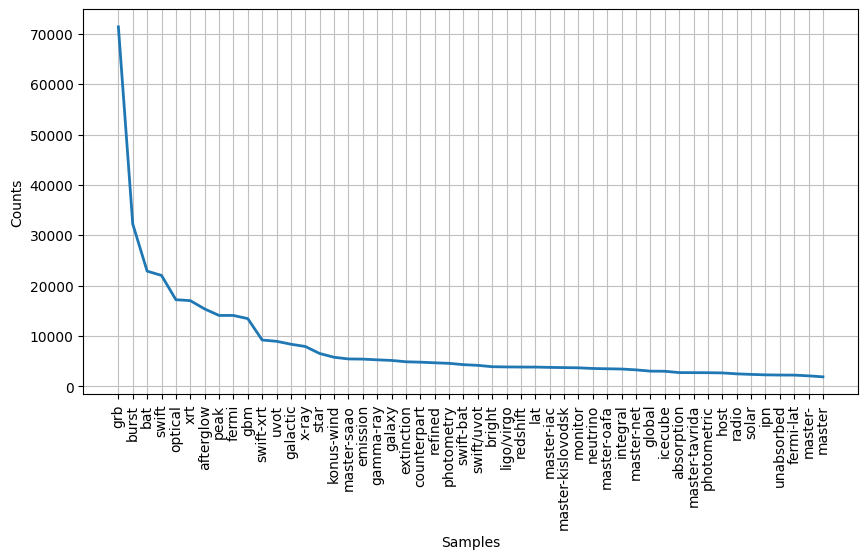

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
'''
Lets now view the frequency statistics for our newly cleaned corpus.
Here we first generate a line chart for the top 50 words.
'''

frequencies = FreqDist(all_tokens)
fig, ax = plt.subplots(figsize=(10,5))
frequencies.plot(50) #Frequencies of 50 most common words as a line chart

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


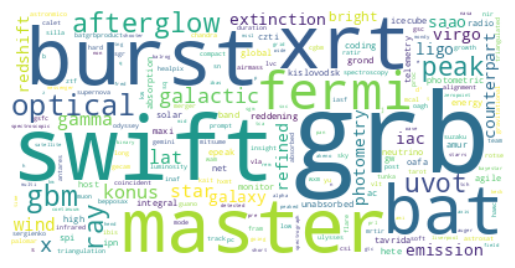

In [ ]:
'''
Generate a new word cloud to help visualize the entire corpus.
'''

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join(all_tokens))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Step 9: Building Dictionary, Bag-of-Words, and TF-IDF Corpus

In [ ]:
'''
Create a dictionary for our vocabulary that we'll be using for our Topic Model.
We'll be using Gensim's corpora package for this.
'''

dictionary = corpora.Dictionary(tokens)
print(f"Number of unique tokens in our dictionary = {len(dictionary)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique tokens in our dictionary = 5397


In [ ]:
'''
Convert each cleaned, tokenized circular in our corpus to a Bag-of-Words vector, again using Gensim.
'''

bow_vectors = [dictionary.doc2bow(circular) for circular in tokens]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
Visualize our first BoW Vector
'''

for vector in bow_vectors[:1]:
  print([(dictionary[id], freq) for id, freq in vector])

[("'shin", 1), ('burst', 1), ('fermi', 2), ('gbm', 2), ('grb', 5), ('grns', 1), ('grs-odyssey', 1), ('hajdas', 1), ('hend', 1), ('ipn', 1), ('konus-wind', 2), ('messenger', 2), ('o=', 5), ('odyssey', 1), ('sq', 1), ('swift', 1), ('swift-bat', 1), ('triangulated', 1), ('triangulation', 1), ('w.', 1)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
Gensim also has a TF-IDF Model which allows us to vectorize our circulars in a slightly different way.
TF-IDF takes into account a word's frequency in the entire corpus as well as it's frequency in each document.
It construct a vector for each document storing information about how important that word is to the document in question.
'''

tfidf = TfidfModel(bow_vectors, normalize=True)
tfidf_vectors = tfidf[bow_vectors]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
Visualize our first TF-IDF Vector
'''

for gcn in tfidf_vectors[:1]:
  print([(dictionary[id], freq) for id, freq in gcn])

[("'shin", 0.12480559906595494), ('burst', 0.015068301615249033), ('fermi', 0.0753963849503301), ('gbm', 0.0825337056524448), ('grb', 0.016629693460128363), ('grns', 0.11475999071937161), ('grs-odyssey', 0.10427597507395082), ('hajdas', 0.12391552311849137), ('hend', 0.09682100054067713), ('ipn', 0.05915166447637761), ('konus-wind', 0.11268246260646728), ('messenger', 0.21389945827503204), ('o=', 0.9046921920690065), ('odyssey', 0.09601260624277363), ('sq', 0.0795363556852293), ('swift', 0.025826742297256185), ('swift-bat', 0.049871015723848375), ('triangulated', 0.07662675187719005), ('triangulation', 0.0682542633655713), ('w.', 0.11403834822970221)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Step 10: Build Topic Model (Latent Dirichlet Allocation)

In [ ]:
'''
Test an LDA Topic Model with just 20 topics.
We use Gensim's LdaModel for this.
'''

lda_model = LdaModel(corpus=bow_vectors, num_topics=20, id2word=dictionary, alpha = 'auto', eta = 'auto')
lda_model.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.130*"czti" + 0.096*"peak" + 0.075*"astrosat" + 0.064*"grb" + 0.036*"hawc" + 0.033*"prl" + 0.025*"emission" + 0.025*"q=grb" + 0.025*"csi" + 0.025*"anticoincidence"'),
 (1,
  '0.125*"peak" + 0.116*"grb" + 0.099*"swift-bat" + 0.091*"bat" + 0.090*"master-oafa" + 0.052*"refined" + 0.042*"telemetry" + 0.042*"coding" + 0.041*"calet" + 0.032*"batgrbproduct"'),
 (2,
  '0.067*"hete" + 0.029*"gecam" + 0.029*"wxm" + 0.028*"chandra" + 0.028*"burst" + 0.018*"fermi-gbm" + 0.017*"counterpart" + 0.016*"fermilab" + 0.015*"fregate" + 0.013*"gecam-b"'),
 (3,
  '0.179*"master-saao" + 0.100*"master-tavrida" + 0.076*"master-net" + 0.076*"global" + 0.046*"fermi" + 0.042*"solar" + 0.035*"galactic" + 0.033*"grb" + 0.030*"yu" + 0.029*"sergienko"'),
 (4,
  '0.275*"master-kislovodsk" + 0.049*"tca" + 0.045*"tch" + 0.043*"fram-cta-n" + 0.037*"fram-auger" + 0.026*"global" + 0.025*"tre" + 0.024*"solar" + 0.021*"master-net" + 0.017*"ligo/virgo"'),
 (5,
  '0.147*"grb" + 0.063*"afterglow" + 0.053*"optical" + 0.

In [ ]:
cm = CoherenceModel(model=lda_model, texts=tokens, coherence='c_npmi')
score = cm.get_coherence()
print(f"The baseline coherence score is: {score}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The baseline coherence score is: -0.03614968273280549


In [ ]:
'''
Grid Search
Score topic models based on coherence score c_npmi
Higher score means more coherent topics
Pick number of topics based on highest c_npmi score
Also check a wide range for the dirchlet priors (a.k.a. alpha and eta)
'''

alpha_values = [0.01, 0.1, 1.0, 10.0]
eta_values = [0.01, 0.1, 1.0, 10.0]
results = []
for i in range(10, 21, 2):
  for j in alpha_values:
    for k in eta_values:
      lda_model = LdaModel(corpus=bow_vectors, num_topics=i, id2word=dictionary, alpha = j, eta = k)
      cm = CoherenceModel(model=lda_model, texts=tokens, coherence='c_npmi')
      score = cm.get_coherence()
      results.append((i, j, k, score))

results = pd.DataFrame(results, columns=['topics', 'alpha', 'eta', 'score'])
display(results)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topics,alpha,eta,score
0,10,0.01,0.01,-0.047787
1,10,0.01,0.10,-0.064829
2,10,0.01,1.00,-0.028225
3,10,0.01,10.00,-0.077605
4,10,0.10,0.01,-0.033642
...,...,...,...,...
91,20,1.00,10.00,-0.048324
92,20,10.00,0.01,-0.033155
93,20,10.00,0.10,-0.040108
94,20,10.00,1.00,-0.036183


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='No. of Topics', ylabel='C_NPMI Score'>

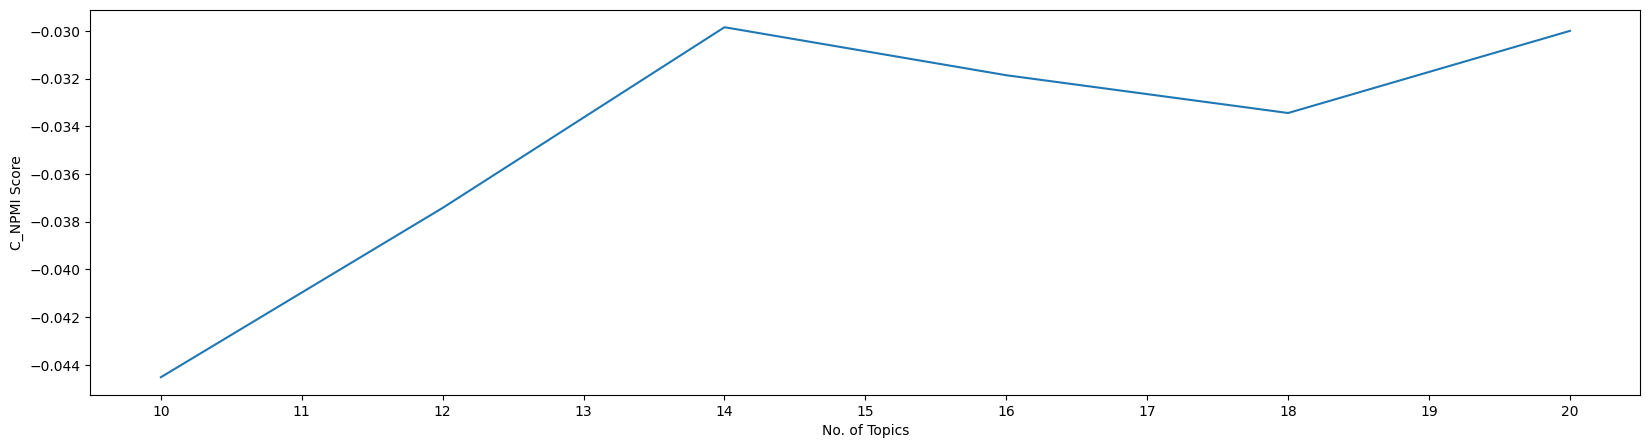

In [ ]:
'''
Plot a graph of coherence scores varying with number of topics.
'''
s = results.groupby('topics')['score'].mean()
fig, ax = plt.subplots(figsize=(20,5))
ax.set_xticks(range(0, len(s), 1))
s.plot(xlabel='No. of Topics', ylabel='C_NPMI Score')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Alpha', ylabel='C_NPMI Score'>

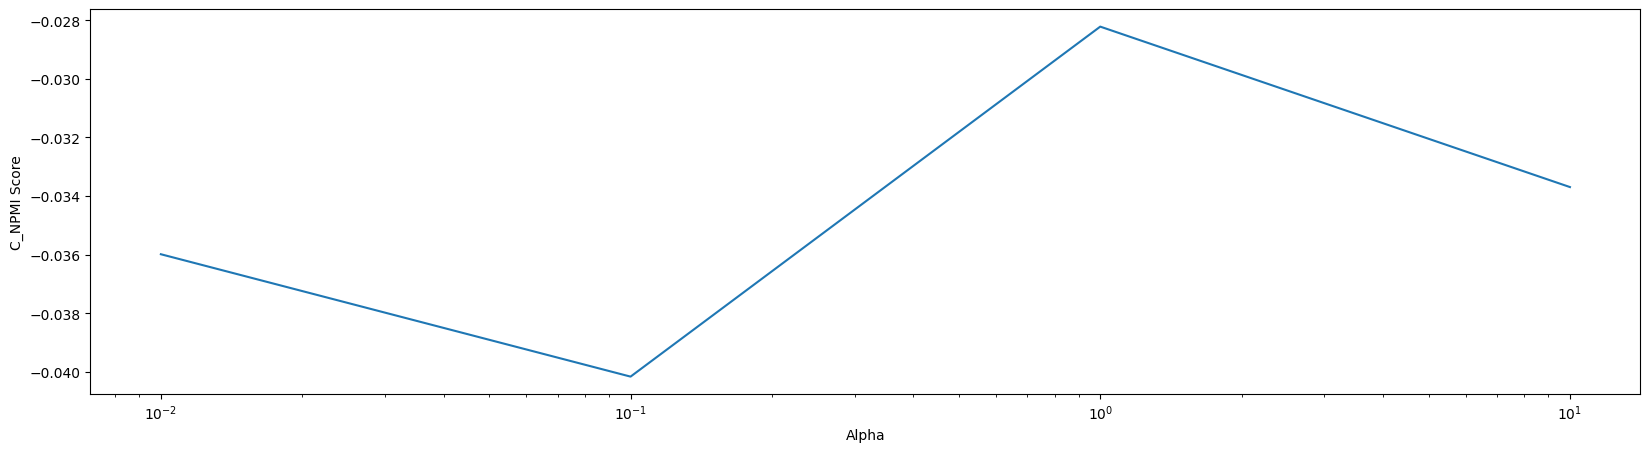

In [ ]:
'''
Plot a graph of coherence scores varying with alpha
'''

s = results.groupby('alpha')['score'].mean()
fig, ax = plt.subplots(figsize=(20,5))
ax.set_xscale('log')
s.plot(xlabel='Alpha', ylabel='C_NPMI Score')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Eta', ylabel='C_NPMI Score'>

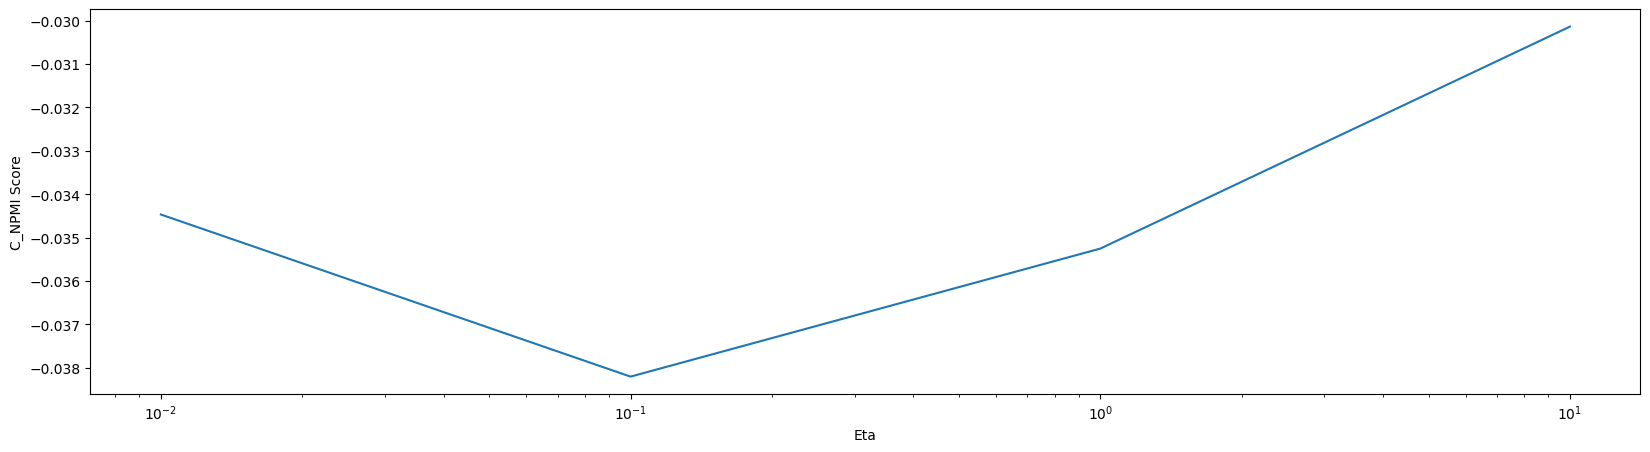

In [ ]:
'''
Plot a graph of coherence scores varying with eta
'''

s = results.groupby('eta')['score'].mean()
fig, ax = plt.subplots(figsize=(20,5))
ax.set_xscale('log')
s.plot(xlabel='Eta', ylabel='C_NPMI Score')

In [ ]:
'''
Get Best Hyperparameters
'''

best = results[results.score == results.score.max()]
alpha = best.alpha.values[0]
eta = best.eta.values[0]
k = best.topics.values[0]

print(f"Best Alpha value is: {alpha}")
print(f"Best Eta value is: {eta}")
print(f"Best K value is: {k}")

Best Alpha value is: 0.01
Best Eta value is: 10.0
Best K value is: 20


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
Generate our model with best hyperparameters
'''

lda_model = LdaModel(corpus=bow_vectors, num_topics=20, id2word=dictionary, alpha = 0.01, eta = 10)
lda_model.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"gecam" + 0.005*"gecam-b" + 0.003*"satellite" + 0.002*"bd" + 0.002*"beijing" + 0.002*"carma" + 0.002*"km" + 0.002*"gravitational" + 0.002*"journal" + 0.002*"wave"'),
 (1,
  '0.011*"sgr" + 0.010*"insight-hxmt" + 0.008*"insight-hxmt/he" + 0.007*"csi" + 0.005*"fermilab" + 0.005*"batse" + 0.003*"gamma-rays" + 0.003*"administration" + 0.003*"penetrate" + 0.003*"leave"'),
 (2,
  '0.047*"peak" + 0.046*"grb" + 0.040*"swift-bat" + 0.037*"bat" + 0.021*"refined" + 0.018*"telemetry" + 0.018*"coding" + 0.014*"batgrbproduct" + 0.007*"emission" + 0.006*"kait"'),
 (3,
  '0.003*"xmm-newton" + 0.002*"snu" + 0.001*"intended" + 0.001*"xmmu" + 0.001*"kasi" + 0.001*"kmtnet" + 0.001*"date_obs" + 0.001*"kim" + 0.001*"/p" + 0.001*"courier"'),
 (4,
  '0.120*"grb" + 0.064*"optical" + 0.043*"afterglow" + 0.024*"star" + 0.018*"photometry" + 0.018*"burst" + 0.010*"xrt" + 0.008*"swift" + 0.007*"counterpart" + 0.007*"mitsume"'),
 (5,
  '0.054*"master-saao" + 0.037*"master-kislovodsk" + 0.035*"master-oaf

In [ ]:
'''
Print coherence score
'''

cm = CoherenceModel(model=lda_model, texts=tokens, coherence='c_npmi')
score = cm.get_coherence()
print(score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.018300126863656445


#Step 11: Visualise Our Results

In [ ]:
'''
Visualise Topic Clusters with pyLDAvis
'''

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus=bow_vectors, dictionary=dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.236533  0.104423       1        1  21.191074
4      0.130693 -0.096063       2        1  20.482198
11     0.185816 -0.029155       3        1  14.204831
6     -0.036338 -0.026080       4        1   8.178261
5     -0.050935  0.126611       5        1   5.794229
19     0.087475 -0.047391       6        1   5.659146
2      0.040649  0.012979       7        1   4.186860
18    -0.065032 -0.005011       8        1   3.560336
7     -0.032258  0.018973       9        1   2.278207
14    -0.019199 -0.006156      10        1   2.145071
9     -0.054590  0.004422      11        1   1.942750
1     -0.045039 -0.006760      12        1   1.890113
16    -0.056432 -0.006548      13        1   1.707668
10    -0.053801 -0.008969      14        1   1.468216
12    -0.050130 -0.012331      15        1   1.347667
15    -0.038917 -0.000258      16        1   1.285572
13    -0.047183 -0.006861      17        1   0.962834
0     -0.043286 -0.004516      18        1   0.639382
17    -0.044213 -0.004657      19        1   0.608520
3     -0.043813 -0.006655      20        1   0.467063, topic_info=           Term          Freq         Total Category  logprob  loglift
48          bat  14229.000000  14229.000000  Default  30.0000  30.0000
15        swift  14847.000000  14847.000000  Default  29.0000  29.0000
4           grb  48975.000000  48975.000000  Default  28.0000  28.0000
3           gbm   9975.000000   9975.000000  Default  27.0000  27.0000
1         burst  22239.000000  22239.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1446       loao      2.329270    132.369921  Topic20  -7.3686   1.3264
1343    content      2.131749    114.762540  Topic20  -7.4572   1.3805
1248       span      1.971981    149.852084  Topic20  -7.5351   1.0359
1163  liverpool      1.894425    331.800040  Topic20  -7.5752   0.2008
1444         br      1.837346    113.515007  Topic20  -7.6058   1.2428

[830 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3717      1  0.101906  'optic'
3717      2  0.114644  'optic'
3717      3  0.089167  'optic'
3717      4  0.089167  'optic'
3717      5  0.101906  'optic'
...     ...       ...      ...
5343     16  0.024399  |fram-c
5343     17  0.012200  |fram-c
5343     18  0.012200  |fram-c
5343     19  0.012200  |fram-c
5343     20  0.012200  |fram-c

[13120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 12, 7, 6, 20, 3, 19, 8, 15, 10, 2, 17, 11, 13, 16, 14, 1, 18, 4])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


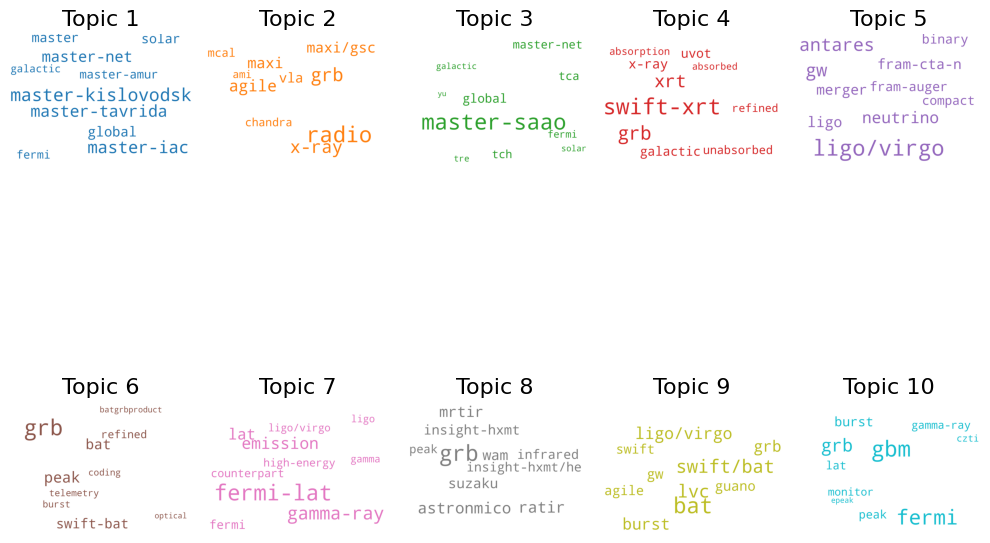

In [ ]:
'''
Word Cluster Visualization
'''

import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + f"{i+1}", fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
